In [ ]:
!pip install sciann
!pip install matplotlib
!pip install scipy
!pip install os
!pip install argparse
#!/usr/bin/env python3

     |████████████████████████████████| 174 kB 32.3 MB/s 
     |████████████████████████████████| 561 kB 59.6 MB/s 
     |████████████████████████████████| 460.3 MB 8.9 kB/s 
     |████████████████████████████████| 132 kB 59.0 MB/s 
     |████████████████████████████████| 4.0 MB 47.1 MB/s 
     |████████████████████████████████| 14.8 MB 60.6 MB/s 
     |████████████████████████████████| 462 kB 69.7 MB/s 
     |████████████████████████████████| 1.2 MB 58.3 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68722 sha256=619779e6272f79c11852d6cdbf797d36c6b755e127648832b96a14b58e790100
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: numpy
    Found existi

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


Streaming output truncated to the last 5000 lines.
Epoch 505/3000
13/13 - 0s - loss: 0.5526 - Uxy_loss: 0.0705 - Vxy_loss: 0.0129 - Sxx_loss: 0.0424 - Syy_loss: 0.0251 - Sxy_loss: 0.0071 - sub_7_loss: 0.0426 - sub_8_loss: 0.0279 - sub_9_loss: 0.0121 - add_17_loss: 0.2448 - add_18_loss: 0.0840 - lr: 0.0010 - time: 0.2359
Epoch 506/3000
13/13 - 0s - loss: 0.4954 - Uxy_loss: 0.0686 - Vxy_loss: 0.0126 - Sxx_loss: 0.0380 - Syy_loss: 0.0267 - Sxy_loss: 0.0075 - sub_7_loss: 0.0483 - sub_8_loss: 0.0403 - sub_9_loss: 0.0097 - add_17_loss: 0.1570 - add_18_loss: 0.0848 - lr: 0.0010 - time: 0.2240
Epoch 507/3000
13/13 - 0s - loss: 0.4459 - Uxy_loss: 0.0680 - Vxy_loss: 0.0122 - Sxx_loss: 0.0432 - Syy_loss: 0.0205 - Sxy_loss: 0.0074 - sub_7_loss: 0.0369 - sub_8_loss: 0.0270 - sub_9_loss: 0.0092 - add_17_loss: 0.1494 - add_18_loss: 0.0673 - lr: 0.0010 - time: 0.2355
Epoch 508/3000
13/13 - 0s - loss: 0.5274 - Uxy_loss: 0.0693 - Vxy_loss: 0.0122 - Sxx_loss: 0.0416 - Syy_loss: 0.0210 - Sxy_loss: 0.0064 

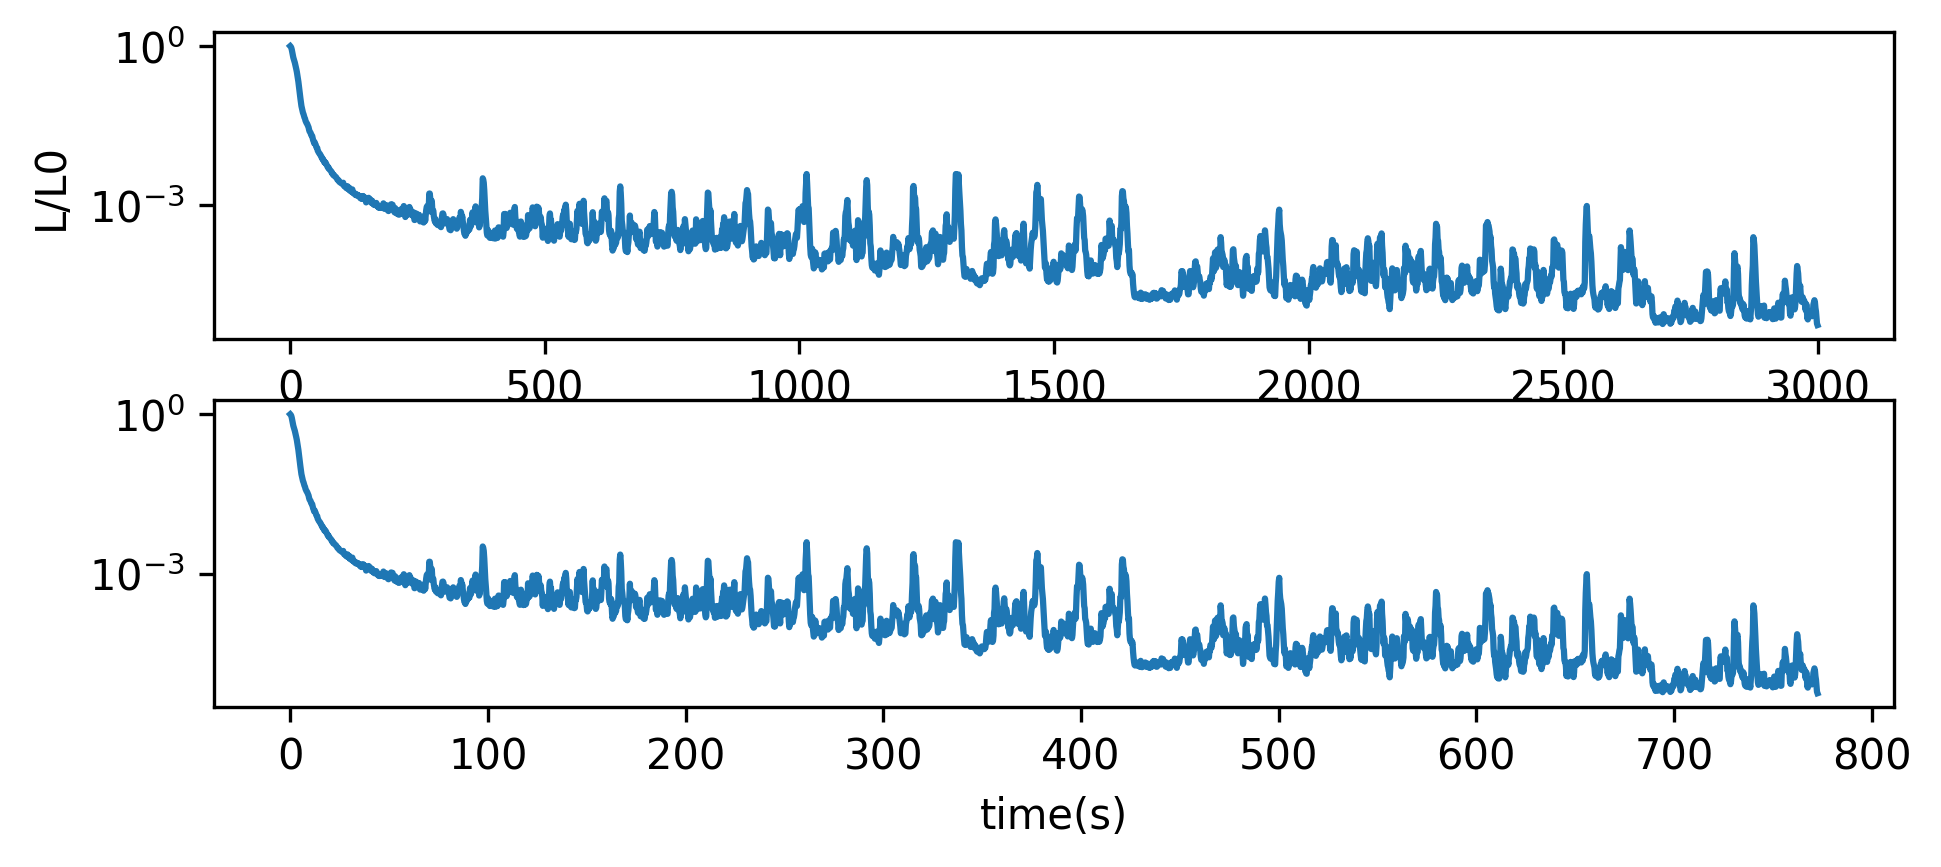

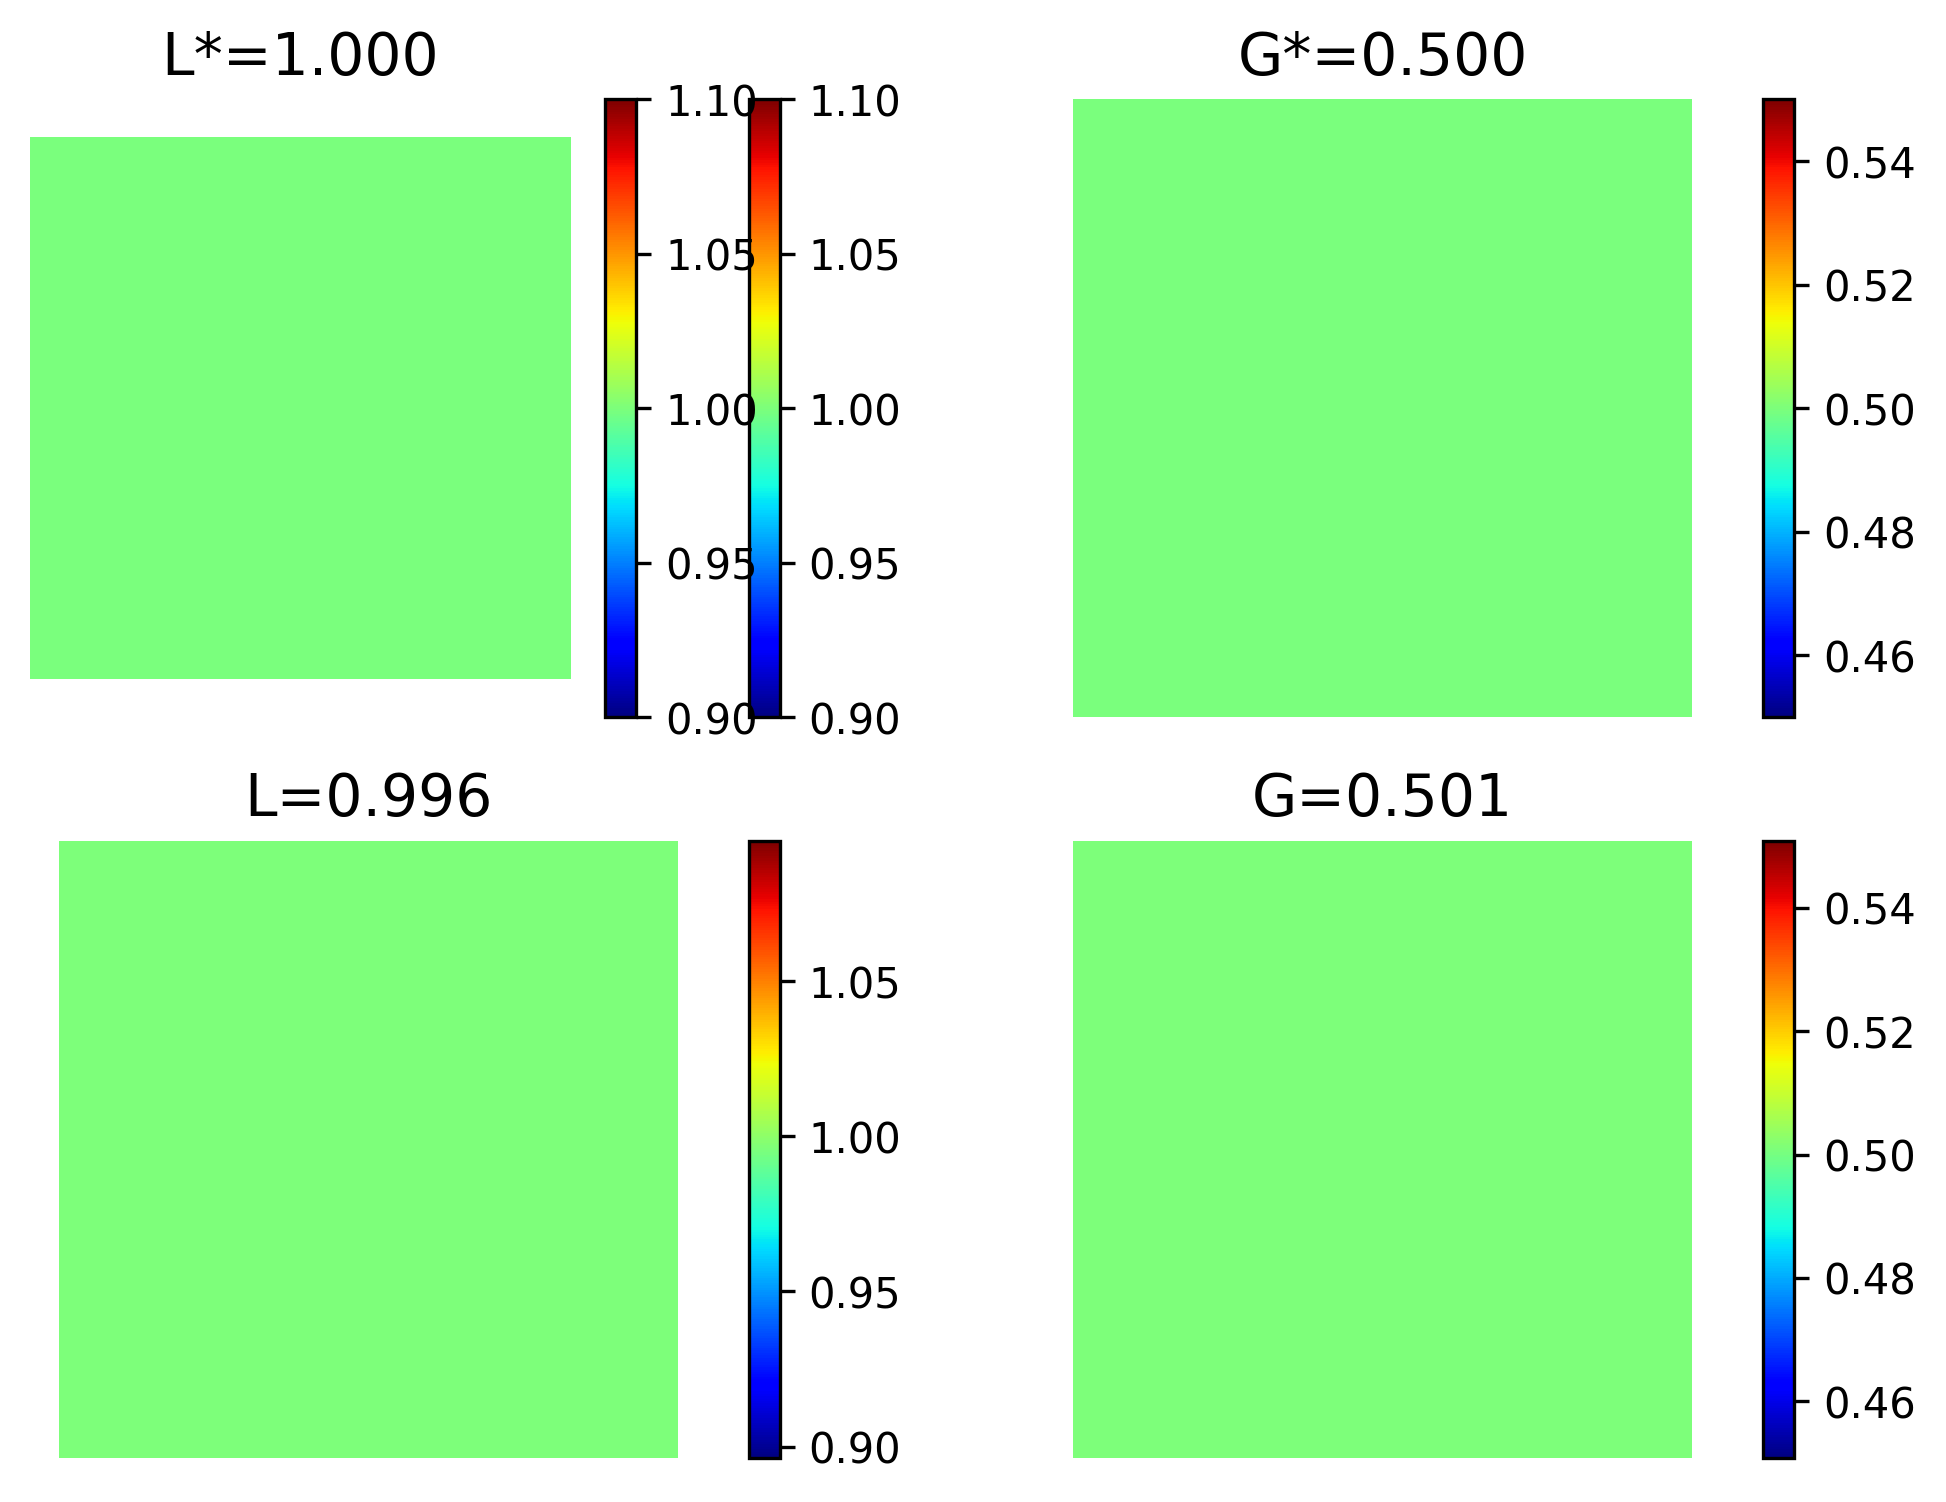

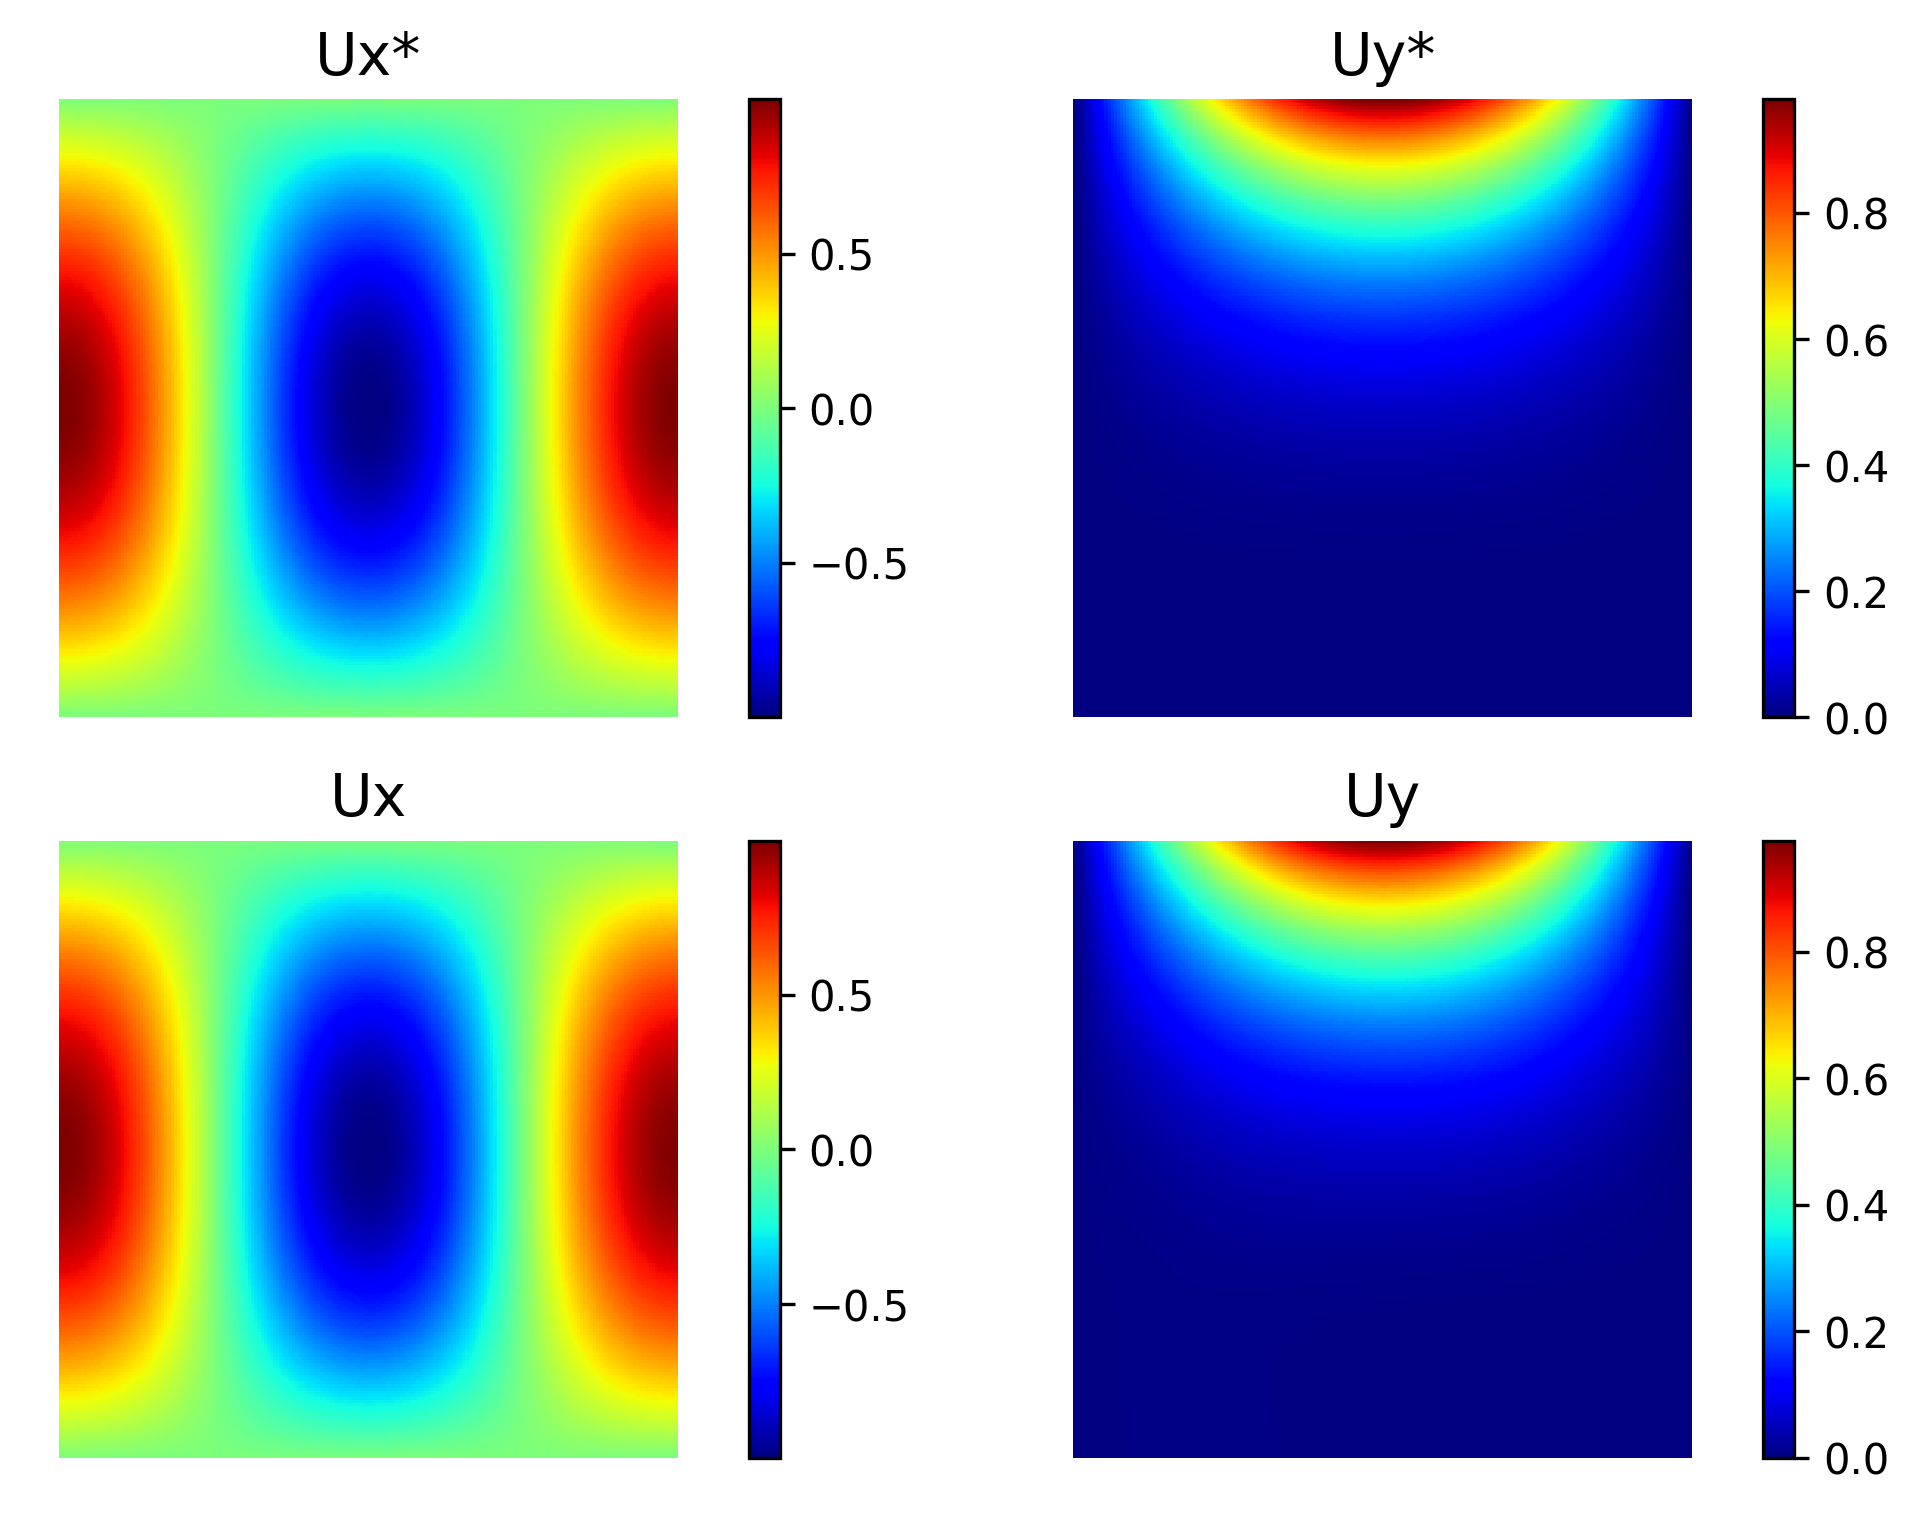

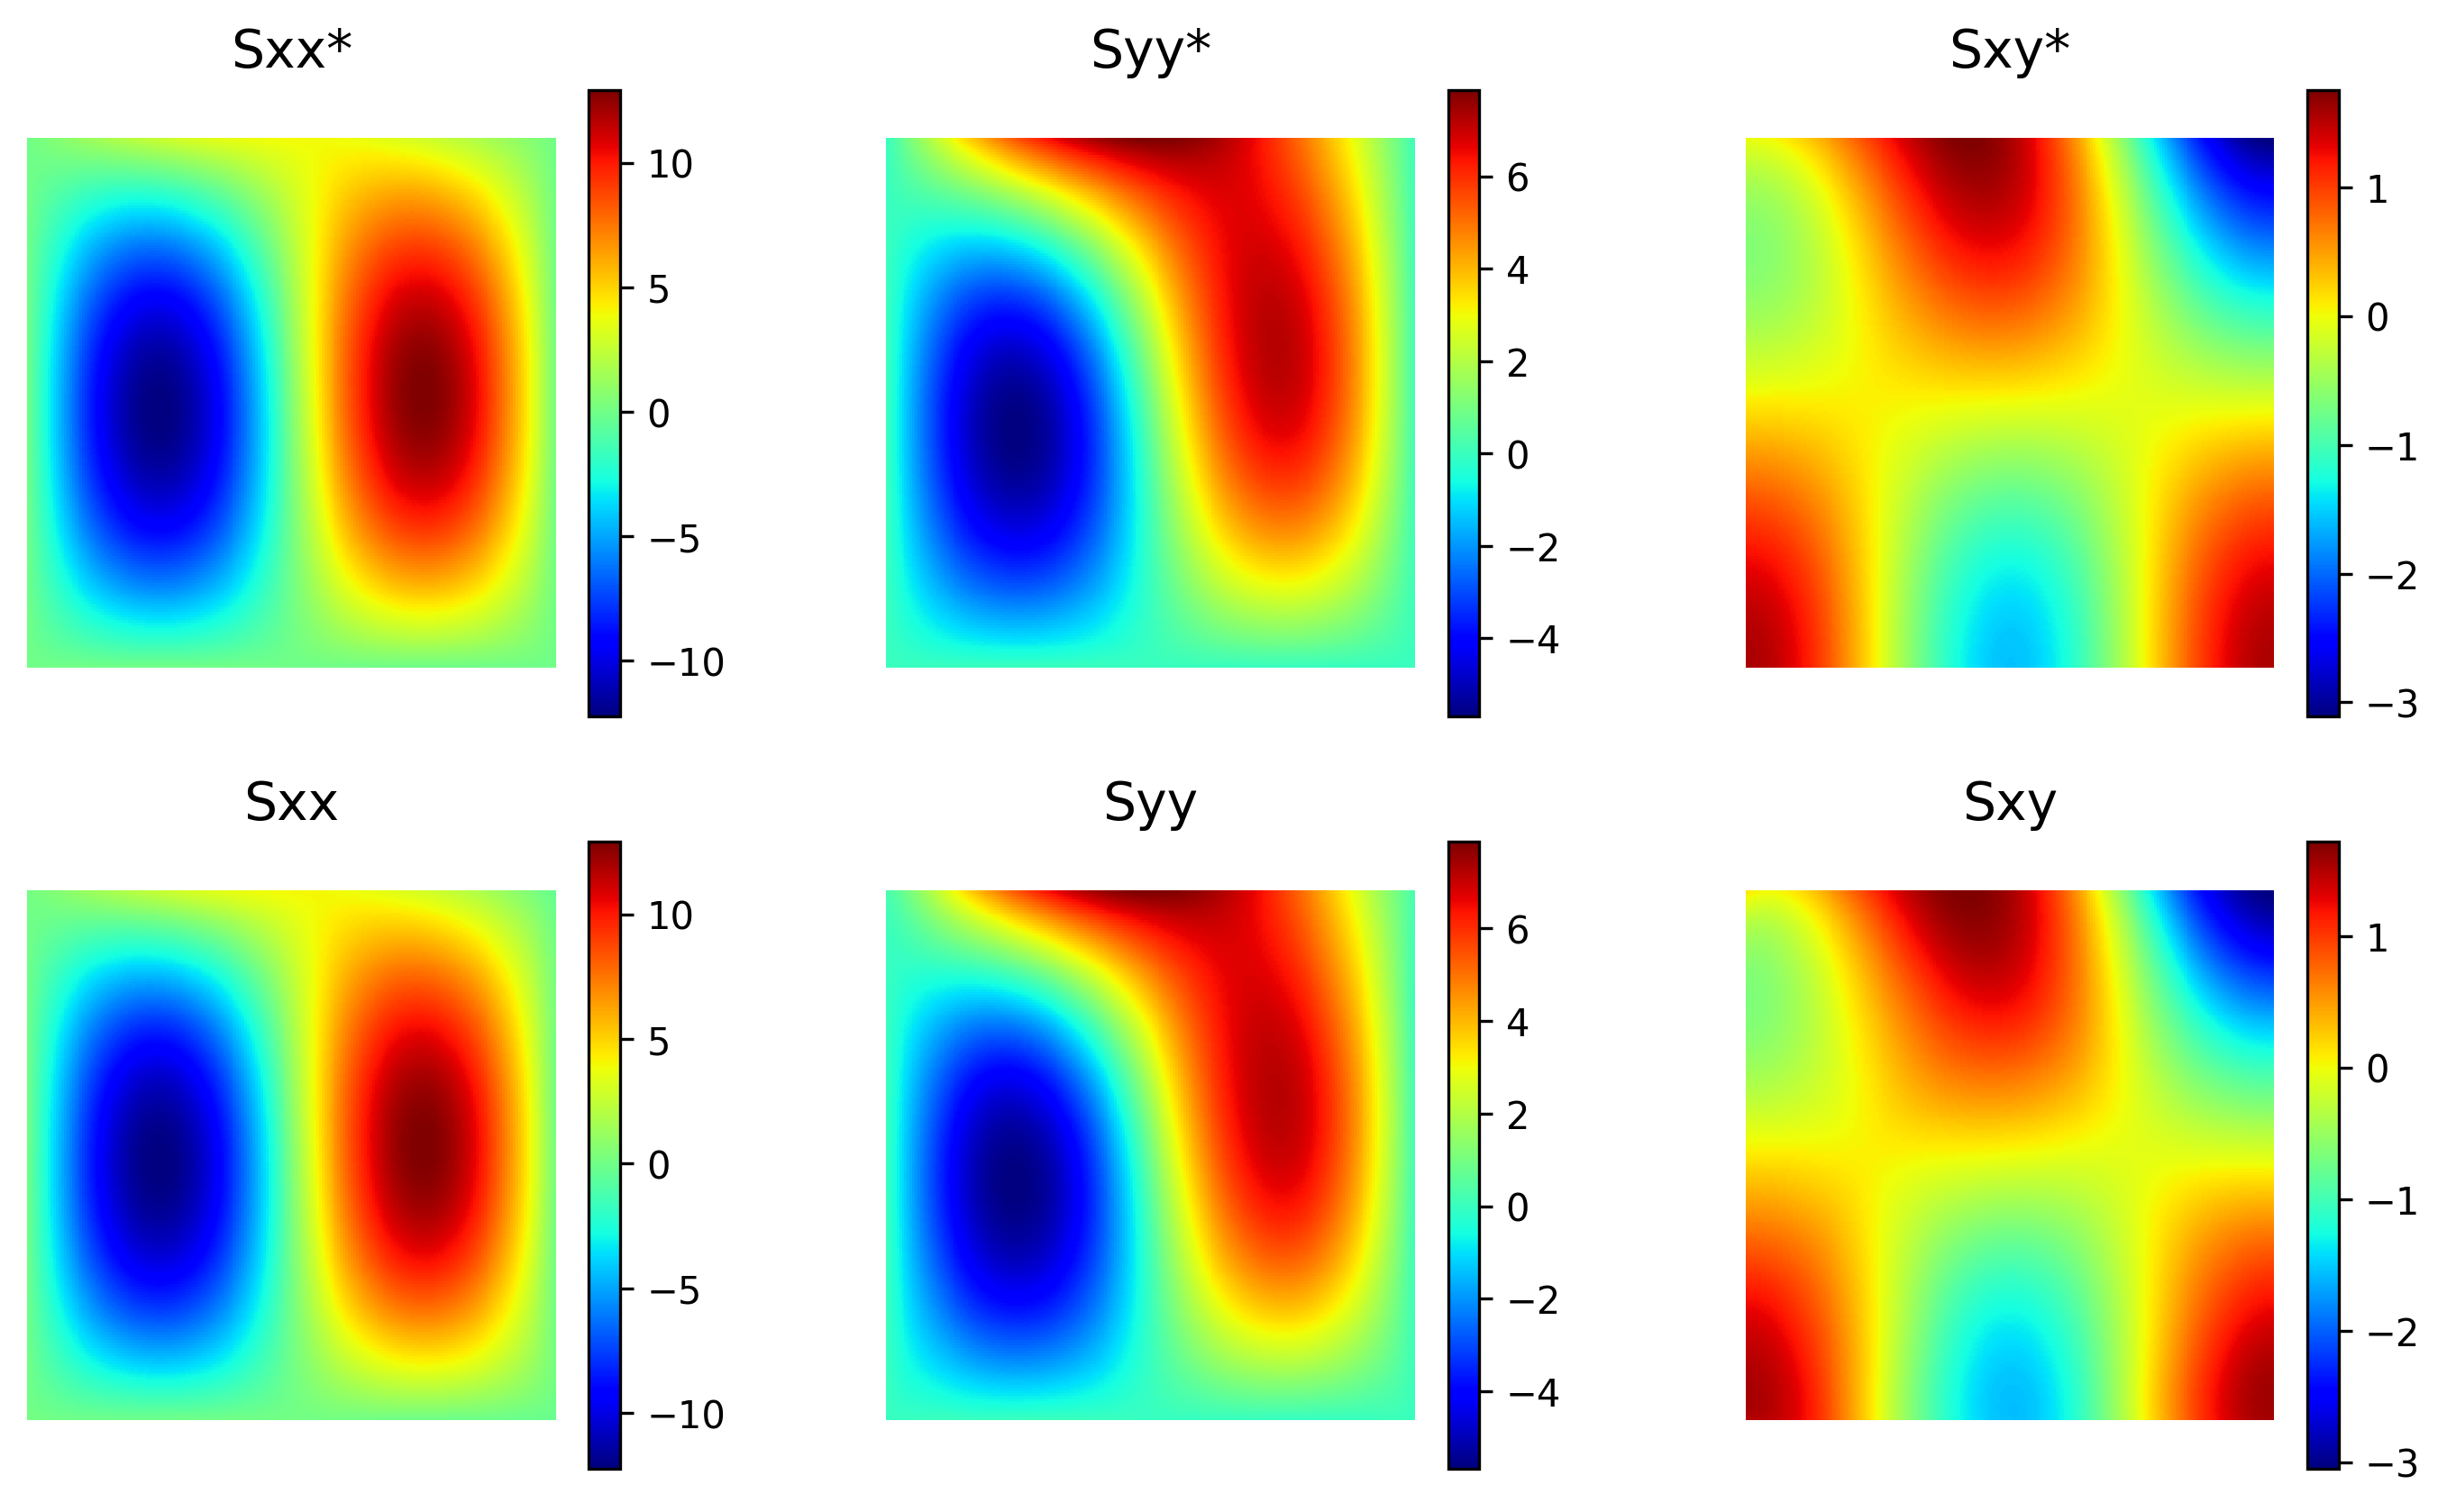

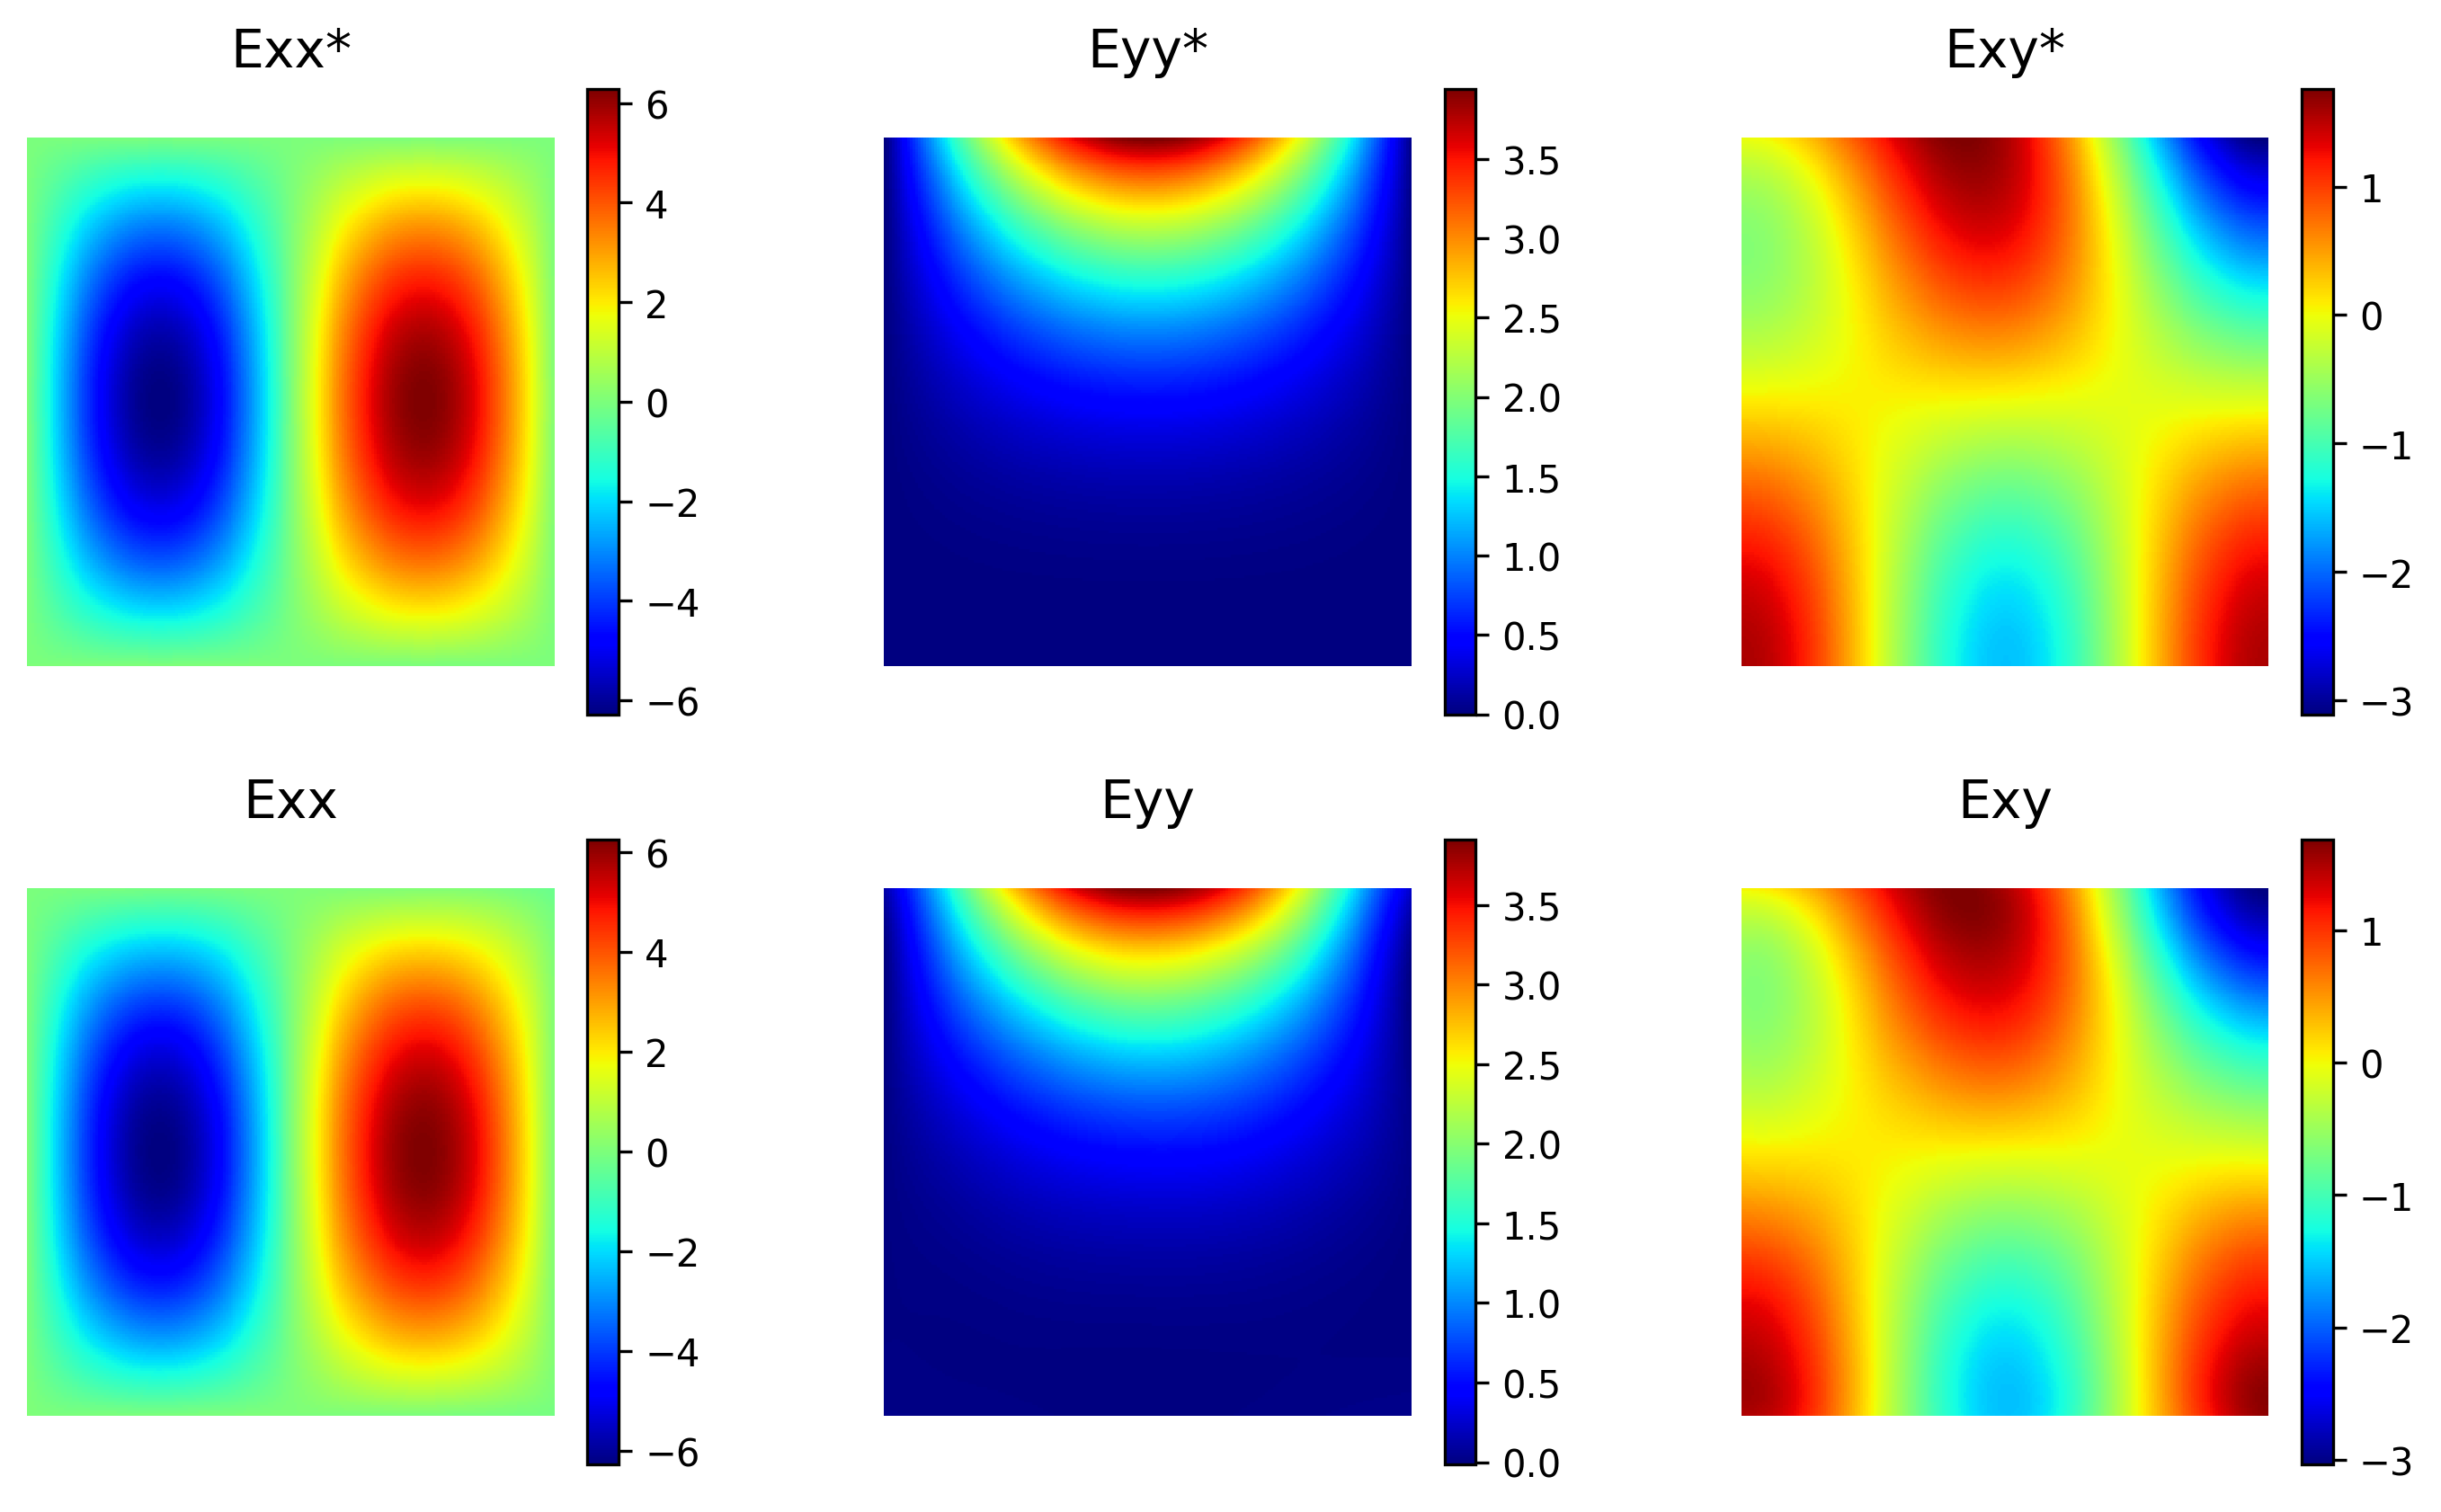

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


import os, sys, time
import numpy as np
from sciann.utils.math import diff
from sciann import SciModel, Functional, Parameter
from sciann import Data, Tie
from sciann import Variable, Field

import matplotlib.pyplot as plt
import argparse
pi = np.pi 

# current file name. 
# current_file_name = os.path.basename(__file__).split(".")[0]

# Lame paramters used in the paper. 
lmbd = 1.0
mu = 0.5
qload = 4.0


# Define the hyper parameters
Layers_n_Neurons = [40]*4
ACTF = 'tanh'
Batchsize = 32
Epochs = 3000
Learning_rate = 0.001
Independent_networks = True
Verbose = 2
Shuffle = True
Stopafter = 1000
Outputprefix = 'res'
Numxplot = 200
Numyplot = 200


# Define number of data points.
Numx = 20
Numy = 20

    

def load(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return Q * np.sin(pi*x)


def bodyfx(xx):
    x, y = xx[0], xx[1]
    Q = qload
    frc = - lmbd*(4*pi**2*np.cos(2*pi*x)*np.sin(pi*y) - Q*y**3*pi*np.cos(pi*x)) \
          - mu*(pi**2*np.cos(2*pi*x)*np.sin(pi*y) - Q*y**3*pi*np.cos(pi*x)) \
          - 8*mu*pi**2*np.cos(2*pi*x)*np.sin(pi*y)
    return frc


def bodyfy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    frc = lmbd*(3*Q*y**2*np.sin(pi*x) - 2*pi**2*np.cos(pi*y)*np.sin(2*pi*x)) \
          - mu*(2*pi**2*np.cos(pi*y)*np.sin(2*pi*x) + (Q*y**4*pi**2*np.sin(pi*x))/4) \
          + 6*Q*mu*y**2*np.sin(pi*x)
    return frc


def dispx(xx):
    x, y = xx[0], xx[1]
    return np.cos(2*pi*x) * np.sin(pi*y)


def dispy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return np.sin(pi*x) * Q * y**4/4


def strainxx(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return -2*pi*np.sin(2*pi*x)*np.sin(pi*y)

def strainyy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return np.sin(pi*x)*Q*y**3

def strainxy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    return 0.5*(pi*np.cos(2*pi*x)*np.cos(pi*y) + pi*np.cos(pi*x)*Q*y**4/4)

def stressxx(xx):
    return (lmbd+2*mu)*strainxx(xx) + lmbd*strainyy(xx)

def stressyy(xx):
    return (lmbd+2*mu)*strainyy(xx) + lmbd*strainxx(xx)

def stressxy(xx):
    return 2.0*mu*strainxy(xx)

def cust_pcolor(AX, X, Y, C, title):
    im = AX.pcolor(X, Y, C, cmap="jet")
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    plt.colorbar(im, ax=AX)

def cust_semilogx(AX, X, Y, xlabel, ylabel):
    if X is None:
        im = AX.semilogy(Y)
    else:
        im = AX.semilogy(X, Y)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)

def train():
    # define output folder. 
    if not os.path.isdir('output'):
        os.mkdir('output')
        
    output_file_name = os.path.join('output', Outputprefix)
    fname = output_file_name + "_{}_".format(ACTF) + "x".join([str(x) for x in Layers_n_Neurons])
    
    # Neural Network Setup.
    x = Variable("x", dtype='float64')
    y = Variable("y", dtype='float64')

    if Independent_networks:
        Uxy = Functional("Uxy", [x, y], Layers_n_Neurons, ACTF)
        Vxy = Functional("Vxy", [x, y], Layers_n_Neurons, ACTF)
        Sxx = Functional("Sxx", [x, y], Layers_n_Neurons, ACTF)
        Syy = Functional("Syy", [x, y], Layers_n_Neurons, ACTF)
        Sxy = Functional("Sxy", [x, y], Layers_n_Neurons, ACTF)

    else:
        Uxy, Vxy, Sxx, Syy, Sxy = Functional(
            ["Uxy", "Vxy", "Sxx", "Syy", "Sxy"],
            [x, y],
            Layers_n_Neurons, ACTF).split()
    
    lame1 = Parameter(2.0, inputs=[x,y], name="lame1")
    lame2 = Parameter(2.0, inputs=[x,y], name="lame2")

    C11 = (2*lame2 + lame1)
    C12 = lame1
    C33 = 2*lame2

    Exx = diff(Uxy, x)
    Eyy = diff(Vxy, y)
    Exy = (diff(Uxy, y) + diff(Vxy, x))*0.5

    # Define constraints 
    d1 = Data(Uxy)
    d2 = Data(Vxy)
    d3 = Data(Sxx)
    d4 = Data(Syy)
    d5 = Data(Sxy)
    
    c1 = Tie(Sxx, Exx*C11 + Eyy*C12)
    c2 = Tie(Syy, Eyy*C11 + Exx*C12)
    c3 = Tie(Sxy, Exy*C33)
    
    Lx = diff(Sxx, x) + diff(Sxy, y)
    Ly = diff(Sxy, x) + diff(Syy, y)
    
    # Define the optimization model (set of inputs and constraints)
    model = SciModel(
        inputs=[x, y],
        targets=[d1, d2, d3, d4, d5, c1, c2, c3, Lx, Ly],
        loss_func="mse"
    )
    with open("{}_summary".format(fname), "w") as fobj:
        model.summary(print_fn=lambda x: fobj.write(x + '\n'))
        
    # Prepare training data 
    ## Training grid 
    XMIN, XMAX = 0.0, 1.0
    YMIN, YMAX = 0.0, 1.0
    Xmesh = np.linspace(XMIN, XMAX, Numx).reshape((-1, 1))
    Ymesh = np.linspace(YMIN, YMAX, Numy).reshape((-1, 1))
    X, Y = np.meshgrid(Xmesh, Ymesh)

    input_data = [X.reshape(-1, 1), Y.reshape(-1, 1)]

    ## data associated to constrains defined earlier 
    # Define constraints 
    data_d1 = dispx(input_data)
    data_d2 = dispy(input_data)
    data_d3 = stressxx(input_data)
    data_d4 = stressyy(input_data)
    data_d5 = stressxy(input_data)
    data_c1 = 'zeros'
    data_c2 = 'zeros'
    data_c3 = 'zeros'
    data_Lx = bodyfx(input_data)
    data_Ly = bodyfy(input_data)
    
    target_data = [data_d1, data_d2, data_d3, data_d4, data_d5, 
                   data_c1, data_c2, data_c3,
                   data_Lx, data_Ly]

    # Train the model 
    training_time = time.time()
    history = model.train(
        x_true=input_data,
        y_true=target_data,
        epochs=Epochs,
        batch_size=Batchsize,
        shuffle=Shuffle,
        learning_rate=Learning_rate,
        stop_after=Stopafter,
        verbose=Verbose,
        )

    training_time = time.time() - training_time

    for loss in history.history:
        np.savetxt(fname+"_{}".format("_".join(loss.split("/"))), 
                    np.array(history.history[loss]).reshape(-1, 1))
    
    time_steps = np.linspace(0, training_time, len(history.history["loss"]))
    np.savetxt(fname+"_Time", time_steps.reshape(-1,1))

    # Post process the trained model.
    Xmesh_plot = np.linspace(XMIN, XMAX, Numxplot).reshape((-1, 1))
    Ymesh_plot = np.linspace(YMIN, YMAX, Numyplot).reshape((-1, 1))
    X_plot, Y_plot = np.meshgrid(Xmesh_plot, Ymesh_plot)
    input_plot = [X_plot.reshape(-1, 1), Y_plot.reshape(-1, 1)]

    lame1_pred = lame1.eval(model, input_plot)
    lame2_pred = lame2.eval(model, input_plot)
    Uxy_pred = Uxy.eval(model, input_plot)
    Vxy_pred = Vxy.eval(model, input_plot)
    Exx_pred = Exx.eval(model, input_plot)
    Eyy_pred = Eyy.eval(model, input_plot)
    Exy_pred = Exy.eval(model, input_plot)
    Sxx_pred = Sxx.eval(model, input_plot)
    Syy_pred = Syy.eval(model, input_plot)
    Sxy_pred = Sxy.eval(model, input_plot)
        
    np.savetxt(fname+"_Xmesh", X_plot, delimiter=', ')
    np.savetxt(fname+"_Ymesh", Y_plot, delimiter=', ')
    np.savetxt(fname+"_lame1", lame1_pred, delimiter=', ')
    np.savetxt(fname+"_lame2", lame2_pred, delimiter=', ')
    np.savetxt(fname+"_Uxy", Uxy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Vxy", Vxy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Exx", Exx_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Eyy", Eyy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Exy", Exy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Sxx", Sxx_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Syy", Syy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Sxy", Sxy_pred.reshape(X_plot.shape), delimiter=', ')


def plot():
    output_file_name = os.path.join('output', Outputprefix)
    fname = output_file_name + "_{}_".format(ACTF) + "x".join([str(x) for x in Layers_n_Neurons])
    
    loss = np.loadtxt(fname+"_loss")
    time = np.loadtxt(fname+"_Time")
    fig, ax = plt.subplots(2, 1, figsize=(7, 3), dpi=300)
    cust_semilogx(ax[0], None, loss/loss[0], "epochs", "L/L0")
    cust_semilogx(ax[1], time, loss/loss[0], "time(s)", None)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig("{}_loss.png".format(output_file_name))
    
    Xmesh = np.loadtxt(fname+"_Xmesh", delimiter=',')
    Ymesh = np.loadtxt(fname+"_Ymesh", delimiter=',')
    
    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*lmbd, "L*={:.3f}".format(lmbd))
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*lmbd, "L*={:.3f}".format(lmbd))
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, np.ones_like(Xmesh)*mu, "G*={:.3f}".format(mu))
    lmbd_pred = np.loadtxt(fname+"_lame1", delimiter=',')
    mu_pred = np.loadtxt(fname+"_lame2", delimiter=',')
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*lmbd_pred, "L={:.3f}".format(lmbd_pred.mean()))
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.ones_like(Xmesh)*mu_pred, "G={:.3f}".format(mu_pred.mean()))
    plt.savefig("{}_Parameters.png".format(output_file_name))
    
    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, dispx([Xmesh, Ymesh]), "Ux*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, dispy([Xmesh, Ymesh]), "Uy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(fname+"_Uxy", delimiter=','), "Ux")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(fname+"_Vxy", delimiter=','), "Uy")
    plt.savefig("{}_Displacement.png".format(output_file_name))
    
    fig, ax = plt.subplots(2, 3, figsize=(11, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, stressxx([Xmesh, Ymesh]), "Sxx*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, stressyy([Xmesh, Ymesh]), "Syy*")
    cust_pcolor(ax[0, 2], Xmesh, Ymesh, stressxy([Xmesh, Ymesh]), "Sxy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(fname+"_Sxx", delimiter=','), "Sxx")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(fname+"_Syy", delimiter=','), "Syy")
    cust_pcolor(ax[1, 2], Xmesh, Ymesh, np.loadtxt(fname+"_Sxy", delimiter=','), "Sxy")
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig("{}_Stress.png".format(output_file_name))
    
    fig, ax = plt.subplots(2, 3, figsize=(11, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, strainxx([Xmesh, Ymesh]), "Exx*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, strainyy([Xmesh, Ymesh]), "Eyy*")
    cust_pcolor(ax[0, 2], Xmesh, Ymesh, strainxy([Xmesh, Ymesh]), "Exy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(fname+"_Exx", delimiter=','), "Exx")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(fname+"_Eyy", delimiter=','), "Eyy")
    cust_pcolor(ax[1, 2], Xmesh, Ymesh, np.loadtxt(fname+"_Exy", delimiter=','), "Exy")
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig("{}_Strain.png".format(output_file_name))
    

if __name__ == "__main__":
    train()
    plot()